In [1]:
import ruleminer
import logging
import sys
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
logging.basicConfig(
    stream=sys.stdout, format="%(asctime)s %(message)s", level=logging.WARNING
)

# Decision tree for iris dataset

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()

## Setup dataframe

In [4]:
df = pd.DataFrame(
    columns=[c.replace(")", "").replace("(", "") for c in iris["feature_names"]],
    data=iris["data"],
)
df["target"] = [iris["target_names"][x] for x in iris["target"]]
df[["target"]] = OrdinalEncoder(dtype=int).fit_transform(df[["target"]])

## Fit ensemble of decision tree (AdaBoost)

In [5]:
features = [col for col in df.columns if col != "target"]
X = df[features]
Y = df[["target"]].values.ravel()
target_dtype = df.dtypes[df.columns.get_loc("target")]

base, estimator = DecisionTreeClassifier, AdaBoostClassifier

regressor = estimator(
    base_estimator=base(
        random_state=0, max_depth=2, min_samples_split=2, min_samples_leaf=1
    ),
    n_estimators=25,
    random_state=0,
)
regressor = regressor.fit(X, Y)

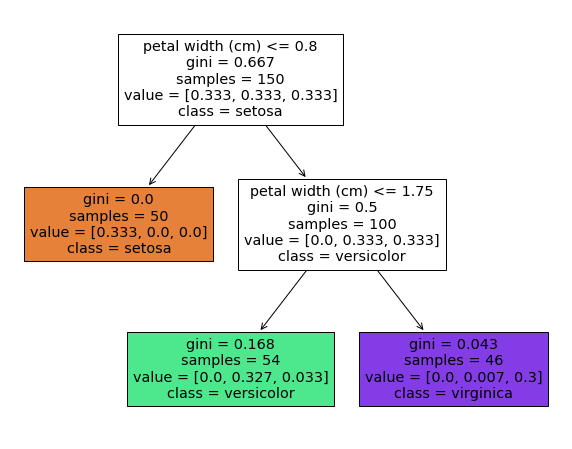

In [6]:
from matplotlib import pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(10, 8))
_ = tree.plot_tree(
    regressor[0],
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
)

In [7]:
# derive expression from tree
ruleminer.tree_to_expressions(regressor[0], features, "target")

{'if (({"petal width cm"} <= 0.800000011920929)) then ({"target"} == 0)',
 'if (({"petal width cm"} > 0.800000011920929) & ({"petal width cm"} <= 1.75)) then ({"target"} == 1)',
 'if (({"petal width cm"} > 0.800000011920929) & ({"petal width cm"} > 1.75)) then ({"target"} == 2)'}

In [8]:
# the above can also be done with the following function
ensemble_expressions = ruleminer.fit_ensemble_and_extract_expressions(
    df, "target", max_depth=2
)

In [9]:
# expressions from the firstt tree in the ensemble
ensemble_expressions[0]

{'if (({"petal width cm"} <= 0.800000011920929)) then ({"target"} == 0)',
 'if (({"petal width cm"} > 0.800000011920929) & ({"petal width cm"} <= 1.75)) then ({"target"} == 1)',
 'if (({"petal width cm"} > 0.800000011920929) & ({"petal width cm"} > 1.75)) then ({"target"} == 2)'}

## Get best rules from the ensemble

In [10]:
# finding the best rules in the ensemble (based on absolute support)
miners = [
    ruleminer.RuleMiner(
        templates=[{"expression": expression} for expression in expressions], data=df
    )
    for expressions in ensemble_expressions
]

In [11]:
best = max(miners, key=lambda miner: miner.rules["abs support"].sum())

In [12]:
# rule in the miner object
best.rules

,rule_id,rule_group,rule_definition,rule_status,abs support,abs exceptions,confidence,encodings
0,0,0,"if(({""petal width cm""}>0.800000011920929)&({""p...",,49,5,0.907407,{}
1,1,0,"if(({""petal width cm""}>0.800000011920929)&({""p...",,45,1,0.978261,{}
2,2,0,"if({""petal width cm""}<=0.800000011920929)then(...",,50,0,1.000000,{}


In [13]:
print(best.rules.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>rule_id</th>
      <th>rule_group</th>
      <th>rule_definition</th>
      <th>rule_status</th>
      <th>abs support</th>
      <th>abs exceptions</th>
      <th>confidence</th>
      <th>encodings</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>0</td>
      <td>if(({"petal width cm"}&gt;0.800000011920929)&amp;({"petal width cm"}&lt;=1.75))then({"target"}==1)</td>
      <td></td>
      <td>49</td>
      <td>5</td>
      <td>0.907407</td>
      <td>{}</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0</td>
      <td>if(({"petal width cm"}&gt;0.800000011920929)&amp;({"petal width cm"}&gt;1.75))then({"target"}==2)</td>
      <td></td>
      <td>45</td>
      <td>1</td>
      <td>0.978261</td>
      <td>{}</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>0</td>
      <td>if({"petal width cm"}&lt;=0.8000

In [14]:
# total support (150 elements in original dataset)
best.rules["abs support"].sum()

144

# Decision tree with insurance data

In [15]:
df = pd.DataFrame(
    columns=[
        "Name",
        "Type",
        "Assets",
        "TV-life",
        "TV-nonlife",
        "Own funds",
        "Excess",
    ],
    data=[
        ["Insurer1", "life insurer", 1000.0, 800.0, 0.0, 200.0, 200.0],
        ["Insurer2", "non-life insurer", 4000.0, 0.0, 3200.0, 800.0, 800.0],
        ["Insurer3", "non-life insurer", 800.0, 0.0, 700.0, 100.0, 100.0],
        ["Insurer4", "life insurer", 2500.0, 1800.0, 0.0, 700.0, 700.0],
        ["Insurer5", "non-life insurer", 2100.0, 0.0, 2200.0, 200.0, 200.0],
        ["Insurer6", "life insurer", 9001.0, 8701.0, 0.0, 300.0, 200.0],
        ["Insurer7", "life insurer", 9002.0, 8802.0, 0.0, 200.0, 200.0],
        ["Insurer8", "life insurer", 9003.0, 8903.0, 0.0, 100.0, 200.0],
        ["Insurer9", "non-life insurer", 9000.0, 8850.0, 0.0, 150.0, 200.0],
        ["Insurer10", "non-life insurer", 9000.0, 0, 8750.0, 250.0, 199.99],
    ],
)
df.index.name = "id"
for i in range(0, 0):
    df = df.append(df, ignore_index=True)

df[["Type"]] = OrdinalEncoder(dtype=int).fit_transform(df[["Type"]])
df[["Name"]] = OrdinalEncoder(dtype=int).fit_transform(df[["Name"]])

In [16]:
expressions = ruleminer.fit_dataframe_to_ensemble(df, min_samples_leaf=1)

In [17]:
# number of expressions
print(len(expressions))

41


In [18]:
templates = [{"expression": solution} for solution in expressions]
params = {"filter": {"confidence": 0.75, "abs support": 2}}
r = ruleminer.RuleMiner(templates=templates, data=df, params=params)

In [19]:
r.rules

,rule_id,rule_group,rule_definition,rule_status,abs support,abs exceptions,confidence,encodings
0,0,0,"if({""TV-life""}>400.0)then({""Type""}==0)",,5,1,0.833333,{}
1,1,0,"if({""TV-life""}<=400.0)then({""Type""}==1)",,4,0,1.000000,{}
2,2,0,"if({""TV-life""}>400.0)then({""TV-nonlife""}==0.0)",,6,0,1.000000,{}


In [20]:
print(r.rules.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>rule_id</th>
      <th>rule_group</th>
      <th>rule_definition</th>
      <th>rule_status</th>
      <th>abs support</th>
      <th>abs exceptions</th>
      <th>confidence</th>
      <th>encodings</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>0</td>
      <td>if({"TV-life"}&gt;400.0)then({"Type"}==0)</td>
      <td></td>
      <td>5</td>
      <td>1</td>
      <td>0.833333</td>
      <td>{}</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0</td>
      <td>if({"TV-life"}&lt;=400.0)then({"Type"}==1)</td>
      <td></td>
      <td>4</td>
      <td>0</td>
      <td>1.000000</td>
      <td>{}</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>0</td>
      <td>if({"TV-life"}&gt;400.0)then({"TV-nonlife"}==0.0)</td>
      <td></td>
      <td>6</td>
      <td>0</td>
      <td>1.000000</td>
      <td>{}</td>

In [21]:
df_r = r.evaluate()

In [22]:
df_r[df_r["result"] == False]

,rule_id,rule_group,rule_definition,rule_status,abs support,abs exceptions,confidence,result,indices
5,0,0,"if({""TV-life""}>400.0)then({""Type""}==0)",,5,1,0.833333,False,8
